# Encoder-Decoder Model with Attention: 1 Layer LSTM & Fasttext Embedding
# (Word Level)

## Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import re
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Flatten, Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [ ]:
data_path = '/content/drive/MyDrive/CS2/2.Datasets/'
model_path = '/content/drive/MyDrive/CS2/3.Models/4_3_Attention-Word-Fasttext/'

In [ ]:
data = pd.read_csv(data_path + 'final_data.csv')
print(data.shape)
data.head()

(101717, 2)


,input_text,output_text
0,"Ofcouse , I love cheap fashion , fast fashion ...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,I 'm gon na earn enough money to study abroad .
4,It is not difficult for me but answer phones a...,It is not difficult for me but answering the p...


## Preprocess Data

In [ ]:
def clean(text):
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

data['input_text'] = data['input_text'].apply(lambda x: clean(x))
data['output_text'] = data['output_text'].apply(lambda x: clean(x))

In [ ]:
def preprocessing(data):
   
    data['input_text_length'] = data['input_text'].str.split().apply(len)
    data['output_text_length'] = data['output_text'].str.split().apply(len)

    data = data[data['input_text_length'] < 25]
    data = data[data['output_text_length'] < 25]

    data['output_text_in'] = '<start> ' + data['output_text'].astype(str)
    data['output_text_out'] = data['output_text'].astype(str) + ' <end>'

    data = data.drop(['input_text_length','output_text_length','output_text'], axis=1)
    return data

In [ ]:
data = preprocessing(data)

data.iloc[0]['output_text_in'] = str(data.iloc[0]['output_text_in'])+' <end>'
data.iloc[0]['output_text_out'] = str(data.iloc[0]['output_text_out'])+' <end>'

print('Shape of Dataset:', data.shape)
data.head()

Shape of Dataset: (93503, 3)


,input_text,output_text_in,output_text_out
0,"Ofcouse , I love cheap fashion , fast fashion ...","<start> Of course , I love cheap , fast fashio...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,<start> If he wants to listen to music that I ...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,<start> This happened because of the cultural ...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,<start> I 'm gon na earn enough money to study...,I 'm gon na earn enough money to study abroad ...
4,It is not difficult for me but answer phones a...,<start> It is not difficult for me but answeri...,It is not difficult for me but answering the p...


## Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
print('Shape of Train Data:', train.shape)
print('Shape of Test Data:', test.shape)

Shape of Train Data: (84152, 3)
Shape of Test Data: (9351, 3)


## Tokenization

In [ ]:
tokenizer_i = Tokenizer(filters="", char_level=False, lower=False)
tokenizer_o = Tokenizer(filters="", char_level=False, lower=False)

tokenizer_i.fit_on_texts(train['input_text'].values)
tokenizer_o.fit_on_texts(train['output_text_in'].values)

vocab_size_input = len(tokenizer_i.word_index.keys())
print('Input Vocab Size:', vocab_size_input)

vocab_size_output = len(tokenizer_o.word_index.keys())
print('Output Vocab Size:', vocab_size_output)

Input Vocab Size: 35510
Output Vocab Size: 29350


In [ ]:
input_vocab = tokenizer_i.word_index
output_vocab = tokenizer_o.word_index

## Fasttext Embedding

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2021-08-12 03:06:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  13.0MB/s    in 51s     

2021-08-12 03:06:55 (12.8 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('wiki-news-300d-1M.vec') 
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded word vectors =', len(embeddings_index))

# create a weight matrix for words in training docs
encoder_embedding_matrix_fast = np.zeros((len(input_vocab)+1, 300))
for word, i in input_vocab.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		encoder_embedding_matrix_fast[i] = embedding_vector
print('Shape of Encoder Embedding Matrix =', encoder_embedding_matrix_fast.shape)

# create a weight matrix for words in training docs
decoder_embedding_matrix_fast = np.zeros((len(output_vocab)+1, 300))
for word, i in output_vocab.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		decoder_embedding_matrix_fast[i] = embedding_vector
print('Shape of Decoder Embedding Matrix =', decoder_embedding_matrix_fast.shape)

Loaded word vectors = 999995
Shape of Encoder Embedding Matrix = (35511, 300)
Shape of Decoder Embedding Matrix = (29351, 300)


## Data Pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tokenizer_i, tokenizer_o, max_len_enc, max_len_dec):
        self.encoder_inps = data['input_text'].values
        self.decoder_inps = data['output_text_in'].values
        self.decoder_outs = data['output_text_out'].values
        self.tokenizer_o = tokenizer_o
        self.tokenizer_i = tokenizer_i
        self.max_len_enc = max_len_enc
        self.max_len_dec = max_len_dec


    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_i.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tokenizer_o.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_o.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_enc, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self): 
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_i, tokenizer_o, 25, 25)
test_dataset  = Dataset(test, tokenizer_i, tokenizer_o, 25, 25)

train_dataloader = Dataloder(train_dataset, batch_size=512)
test_dataloader = Dataloder(test_dataset, batch_size=512)

print('Train Dataloader:', train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print('Test Dataloader:', test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

Train Dataloader: (512, 25) (512, 25) (512, 25)
Test Dataloader: (512, 25) (512, 25) (512, 25)


## Model Building

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self,in_vocab_size,embedding_dim,enc_units,input_length):
        super().__init__()
        self.in_vocab_size = in_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units = enc_units

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.in_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, weights=[encoder_embedding_matrix_fast], trainable=False, name="Encoder_Embedding")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentences, training=True):
        input_embed = self.embedding(input_sentences)
        encoder_output, encoder_state_h, encoder_state_c = self.lstm(input_embed)
        return encoder_output, encoder_state_h, encoder_state_c

#-----------------------------------------------------------------------------------------------------------------------------------
class Attention(tf.keras.layers.Layer):
  '''
  Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units

    if self.scoring_function == 'dot':
      pass

    if scoring_function == 'general':
      self.W = Dense(self.att_units)
      
    elif scoring_function == 'concat':
      self.W1 = Dense(self.att_units)
      self.W2 = Dense(self.att_units)
      self.Va = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    if self.scoring_function == 'dot':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(encoder_output, decoder_hidden_state)

    elif self.scoring_function == 'general':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(self.W(encoder_output), decoder_hidden_state)

    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.Va(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))

    attention_weight = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum(attention_weight * encoder_output, axis=1)
    return context_vector, attention_weight

#-----------------------------------------------------------------------------------------------------------------------------------
class One_Step_Decoder(tf.keras.Model):
  def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units= dec_units
      self.score_fun = score_fun
      self.att_units = att_units

  def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, weights=[decoder_embedding_matrix_fast], trainable=False, name="Decoder_Embedding")
        self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
        self.dense = Dense(self.tar_vocab_size)
        self.attention = Attention(self.score_fun, self.att_units)

  def call(self,input_to_decoder, encoder_output, state_h, state_c):
    
    target_embedd = self.embedding(input_to_decoder)

    context_vector, attention_weights = self.attention(state_h, encoder_output)
    context_vector = tf.expand_dims(context_vector, 1)

    decoder_input = tf.concat([target_embedd, context_vector], 2)

    decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(decoder_input, initial_state=[state_h,state_c])

    output = self.dense(decoder_output)

    return tf.squeeze(output), decoder_final_state_h, decoder_final_state_c, attention_weights, tf.squeeze(context_vector)

#-----------------------------------------------------------------------------------------------------------------------------------
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun, att_units):
      super(Decoder, self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.one_step_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

   
    def call(self, input_to_decoder, encoder_output_state, decoder_hidden_state, decoder_cell_state):
      all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name="output_arrays")

      for timestep in range(tf.shape(input_to_decoder)[1]):
        output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:,timestep:timestep+1], encoder_output_state, decoder_hidden_state, decoder_cell_state)
        all_outputs = all_outputs.write(timestep, output)

      all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
      return all_outputs

#-----------------------------------------------------------------------------------------------------------------------------------
class Encoder_Decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length, decoder_inputs_length, input_vocab_size, output_vocab_size, embedding_dim, enc_units, dec_units, att_units, batch_size, score_fun, name='Encoder-Decoder-Attention'):
    super().__init__(name=name)
    self.encoder = Encoder(in_vocab_size=input_vocab_size+1, embedding_dim=embedding_dim, enc_units=enc_units, input_length=encoder_inputs_length)
    self.decoder = Decoder(out_vocab_size=output_vocab_size+1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.batch_size = batch_size

  def call(self,data):

    input, output = data[0], data[1]

    encoder_output, encoder_h, encoder_c = self.encoder(input)
    decoder_output = self.decoder(output, encoder_output, encoder_h, encoder_c)
    return decoder_output

## Custom Loss Function

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Model Training

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=256, 
                          dec_units=256, 
                          att_units=256,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)

20 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history20 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 127s 743ms/step - loss: 3.2075 - val_loss: 2.9430
Epoch 2/20
164/164 [==============================] - 120s 734ms/step - loss: 2.9280 - val_loss: 2.8667
Epoch 3/20
164/164 [==============================] - 120s 734ms/step - loss: 2.7913 - val_loss: 2.6812
Epoch 4/20
164/164 [==============================] - 121s 736ms/step - loss: 2.5940 - val_loss: 2.4662
Epoch 5/20
164/164 [==============================] - 120s 734ms/step - loss: 2.3684 - val_loss: 2.2426
Epoch 6/20
164/164 [==============================] - 120s 734ms/step - loss: 2.1649 - val_loss: 2.0588
Epoch 7/20
164/164 [==============================] - 119s 729ms/step - loss: 1.9987 - val_loss: 1.9087
Epoch 8/20
164/164 [==============================] - 120s 732ms/step - loss: 1.8603 - val_loss: 1.7764
Epoch 9/20
164/164 [==============================] - 121s 736ms/step - loss: 1.7280 - val_loss: 1.6438
Epoch 10/20
164/164 [==============================] - 120s 731m

In [ ]:
model.save_weights(model_path + 'att20/' + 'attention20', save_format='tf') 

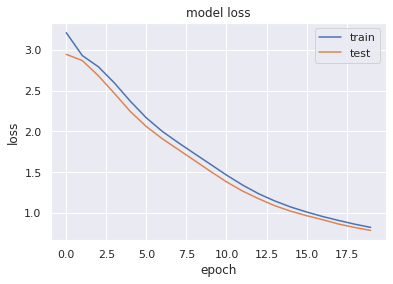

In [ ]:
plt.plot(history20.history['loss'])
plt.plot(history20.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

Model: "Encoder-Decoder-Attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  11223668  
_________________________________________________________________
decoder_2 (Decoder)          multiple                  17181019  
Total params: 28,404,687
Trainable params: 8,946,087
Non-trainable params: 19,458,600
_________________________________________________________________


40 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history40 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 121s 739ms/step - loss: 0.7883 - val_loss: 0.7539
Epoch 2/20
164/164 [==============================] - 121s 738ms/step - loss: 0.7573 - val_loss: 0.7268
Epoch 3/20
164/164 [==============================] - 120s 732ms/step - loss: 0.7264 - val_loss: 0.6938
Epoch 4/20
164/164 [==============================] - 121s 736ms/step - loss: 0.6982 - val_loss: 0.6683
Epoch 5/20
164/164 [==============================] - 121s 738ms/step - loss: 0.6749 - val_loss: 0.6505
Epoch 6/20
164/164 [==============================] - 120s 733ms/step - loss: 0.6529 - val_loss: 0.6261
Epoch 7/20
164/164 [==============================] - 121s 737ms/step - loss: 0.6303 - val_loss: 0.6074
Epoch 8/20
164/164 [==============================] - 120s 733ms/step - loss: 0.6130 - val_loss: 0.5944
Epoch 9/20
164/164 [==============================] - 120s 734ms/step - loss: 0.5962 - val_loss: 0.5761
Epoch 10/20
164/164 [==============================] - 120s 734m

In [ ]:
model.save_weights(model_path + 'att40/' + 'attention40', save_format='tf') 

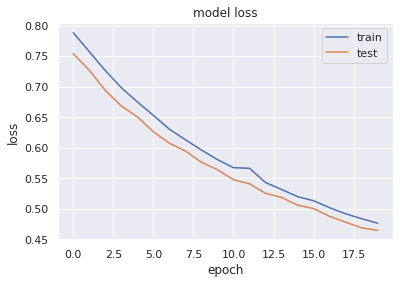

In [ ]:
plt.plot(history40.history['loss'])
plt.plot(history40.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

60 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history60 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 120s 734ms/step - loss: 0.4671 - val_loss: 0.4528
Epoch 2/20
164/164 [==============================] - 120s 733ms/step - loss: 0.4589 - val_loss: 0.4463
Epoch 3/20
164/164 [==============================] - 121s 738ms/step - loss: 0.4531 - val_loss: 0.4428
Epoch 4/20
164/164 [==============================] - 120s 731ms/step - loss: 0.4461 - val_loss: 0.4356
Epoch 5/20
164/164 [==============================] - 120s 735ms/step - loss: 0.4441 - val_loss: 0.4292
Epoch 6/20
164/164 [==============================] - 120s 734ms/step - loss: 0.4346 - val_loss: 0.4209
Epoch 7/20
164/164 [==============================] - 120s 735ms/step - loss: 0.4247 - val_loss: 0.4172
Epoch 8/20
164/164 [==============================] - 121s 738ms/step - loss: 0.4200 - val_loss: 0.4076
Epoch 9/20
164/164 [==============================] - 120s 734ms/step - loss: 0.4120 - val_loss: 0.4002
Epoch 10/20
164/164 [==============================] - 121s 736m

In [ ]:
model.save_weights(model_path + 'att60/' + 'attention60', save_format='tf') 

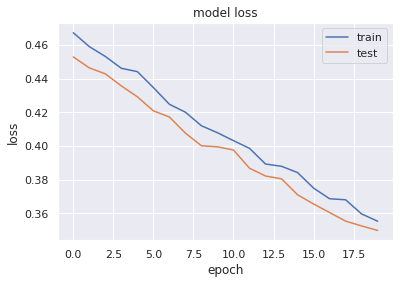

In [ ]:
plt.plot(history60.history['loss'])
plt.plot(history60.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

80 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history80 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 121s 737ms/step - loss: 0.3523 - val_loss: 0.3411
Epoch 2/20
164/164 [==============================] - 119s 729ms/step - loss: 0.3465 - val_loss: 0.3384
Epoch 3/20
164/164 [==============================] - 120s 730ms/step - loss: 0.3404 - val_loss: 0.3318
Epoch 4/20
164/164 [==============================] - 120s 735ms/step - loss: 0.3388 - val_loss: 0.3356
Epoch 5/20
164/164 [==============================] - 120s 731ms/step - loss: 0.3346 - val_loss: 0.3271
Epoch 6/20
164/164 [==============================] - 120s 733ms/step - loss: 0.3354 - val_loss: 0.3242
Epoch 7/20
164/164 [==============================] - 120s 730ms/step - loss: 0.3259 - val_loss: 0.3164
Epoch 8/20
164/164 [==============================] - 120s 730ms/step - loss: 0.3187 - val_loss: 0.3142
Epoch 9/20
164/164 [==============================] - 121s 737ms/step - loss: 0.3157 - val_loss: 0.3118
Epoch 10/20
164/164 [==============================] - 121s 736m

In [ ]:
model.save_weights(model_path + 'att80/' + 'attention80', save_format='tf') 

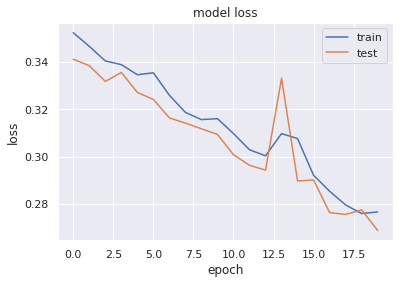

In [ ]:
plt.plot(history80.history['loss'])
plt.plot(history80.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

90 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history90 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 137s 780ms/step - loss: 0.2873 - val_loss: 0.3225
Epoch 2/10
164/164 [==============================] - 125s 766ms/step - loss: 0.2821 - val_loss: 0.2683
Epoch 3/10
164/164 [==============================] - 125s 761ms/step - loss: 0.2673 - val_loss: 0.2670
Epoch 4/10
164/164 [==============================] - 125s 760ms/step - loss: 0.2613 - val_loss: 0.2541
Epoch 5/10
164/164 [==============================] - 125s 763ms/step - loss: 0.2558 - val_loss: 0.2552
Epoch 6/10
164/164 [==============================] - 125s 760ms/step - loss: 0.2532 - val_loss: 0.2480
Epoch 7/10
164/164 [==============================] - 125s 764ms/step - loss: 0.2536 - val_loss: 0.2506
Epoch 8/10
164/164 [==============================] - 125s 763ms/step - loss: 0.2524 - val_loss: 0.2493
Epoch 9/10
164/164 [==============================] - 124s 760ms/step - loss: 0.2468 - val_loss: 0.2422
Epoch 10/10
164/164 [==============================] - 125s 762m

In [ ]:
model.save_weights(model_path + 'att90/' + 'attention90', save_format='tf') 

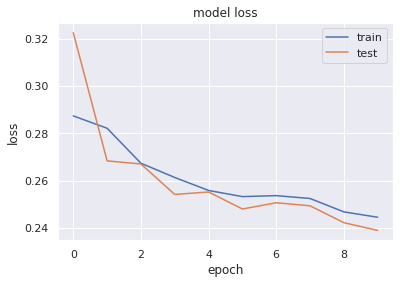

In [ ]:
plt.plot(history90.history['loss'])
plt.plot(history90.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

100 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history100 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 126s 769ms/step - loss: 0.2396 - val_loss: 0.2354
Epoch 2/10
164/164 [==============================] - 126s 769ms/step - loss: 0.2343 - val_loss: 0.2294
Epoch 3/10
164/164 [==============================] - 125s 763ms/step - loss: 0.2486 - val_loss: 0.2319
Epoch 4/10
164/164 [==============================] - 125s 763ms/step - loss: 0.2381 - val_loss: 0.2319
Epoch 5/10
164/164 [==============================] - 125s 763ms/step - loss: 0.2326 - val_loss: 0.2283
Epoch 6/10
164/164 [==============================] - 124s 756ms/step - loss: 0.2272 - val_loss: 0.2254
Epoch 7/10
164/164 [==============================] - 124s 758ms/step - loss: 0.2282 - val_loss: 0.2181
Epoch 8/10
164/164 [==============================] - 125s 762ms/step - loss: 0.2214 - val_loss: 0.2198
Epoch 9/10
164/164 [==============================] - 124s 758ms/step - loss: 0.2210 - val_loss: 0.2115
Epoch 10/10
164/164 [==============================] - 124s 757m

In [ ]:
model.save_weights(model_path + 'att100/' + 'attention100', save_format='tf') 

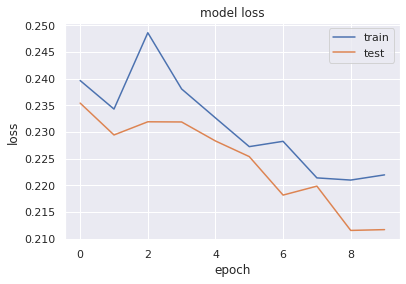

In [ ]:
plt.plot(history100.history['loss'])
plt.plot(history100.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

110 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history110 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 125s 764ms/step - loss: 0.2097 - val_loss: 0.2068
Epoch 2/10
164/164 [==============================] - 125s 761ms/step - loss: 0.2086 - val_loss: 0.2053
Epoch 3/10
164/164 [==============================] - 124s 755ms/step - loss: 0.2052 - val_loss: 0.2059
Epoch 4/10
164/164 [==============================] - 125s 761ms/step - loss: 0.2009 - val_loss: 0.1983
Epoch 5/10
164/164 [==============================] - 124s 757ms/step - loss: 0.2022 - val_loss: 0.2062
Epoch 6/10
164/164 [==============================] - 124s 760ms/step - loss: 0.2014 - val_loss: 0.1978
Epoch 7/10
164/164 [==============================] - 124s 757ms/step - loss: 0.1978 - val_loss: 0.1940
Epoch 8/10
164/164 [==============================] - 124s 760ms/step - loss: 0.2024 - val_loss: 0.2006
Epoch 9/10
164/164 [==============================] - 124s 757ms/step - loss: 0.2047 - val_loss: 0.2195
Epoch 10/10
164/164 [==============================] - 124s 760m

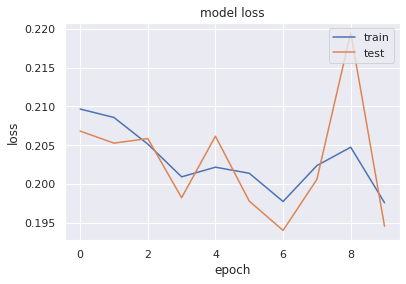

In [ ]:
plt.plot(history110.history['loss'])
plt.plot(history110.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model Prediction

In [ ]:
def predict(input_sentence):

  batch_size = 1 
  DECODER_SEQ_LEN = 25
  predict_word_idx = np.zeros((1, 1))
  predict_word_idx[0,0] = 1
  predicted_sentence = ''

  input_sequence=tokenizer_i.texts_to_sequences([input_sentence])
  inputs=pad_sequences(input_sequence,maxlen=25,padding='post')
  inputs=tf.convert_to_tensor(inputs)

  enc_output, state_h, state_c = model.layers[0](inputs)

  for i in range(DECODER_SEQ_LEN):
      dec_output, state_h, state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(predict_word_idx, enc_output, state_h, state_c)
      predict_word_idx = np.reshape(np.argmax(dec_output), (1, 1))
      predicted_sentence += ' ' + tokenizer_o.index_word[int(predict_word_idx)]

      if tokenizer_o.word_index['<end>'] == predict_word_idx:
          return predicted_sentence
      dec_input = tf.expand_dims([predict_word_idx],0)
  return predicted_sentence

#----------------------------------------------------------------------------------------------------
import nltk.translate.bleu_score as bleu

def get_BLEU(model, train, test):
    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(train['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(train['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    train_avg_bleu = total_bleu/input_range

    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(test['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(test['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    test_avg_bleu = total_bleu/input_range

    print('Train BLEU Score:', train_avg_bleu)
    print('Test BLEU Score:', test_avg_bleu)

In [ ]:
print('SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS')
print('-'*50)

print('Epoch 20')
model.load_weights(model_path + 'att20/' + 'attention20')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 40')
model.load_weights(model_path + 'att40/' + 'attention40')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 60')
model.load_weights(model_path + 'att60/' + 'attention60')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 80')
model.load_weights(model_path + 'att80/' + 'attention80')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 90')
model.load_weights(model_path + 'att90/' + 'attention90')
get_BLEU(model, train, test)
print('='*50)

SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS
--------------------------------------------------
Epoch 20
Train BLEU Score: 0.5058198414171543
Test BLEU Score: 0.4762655447244908
Epoch 40
Train BLEU Score: 0.6076822725152745
Test BLEU Score: 0.5206825956932373
Epoch 60
Train BLEU Score: 0.6285549680070726
Test BLEU Score: 0.5232126867765783
Epoch 80
Train BLEU Score: 0.6925298712804873
Test BLEU Score: 0.5003788725388416
Epoch 90
Train BLEU Score: 0.6924748784932001
Test BLEU Score: 0.493802554025446


In [ ]:
model.load_weights(model_path + 'att60/' + 'attention60')

Train

In [ ]:
for i in range(len(train[:5])):
    print("Input Text:", train['input_text'].iloc[i])
    print("Output Text:", ' '.join(train['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(train['input_text'].iloc[i]).split()[:-1]))
    print('='*120)

Input Text: At the party , the member has variety job .
Output Text: At the party , the members have a variety of jobs .
Predicted Text: At the party , the members have a variety job .
Input Text: Thank you NY .
Output Text: Thank you , NY !
Predicted Text: Thank you .
Input Text: Few last days have been strange .
Output Text: The last few days have been strange .
Predicted Text: A few days have been a strange .
Input Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking for with people around me .
Output Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with the people around me .
Predicted Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with with people around me .
Input Text: We also often listen to the CD which includes the conversation amongst native speakers .
Output Text: We also often listened to the CD which includes conve

Test

In [ ]:
for i in range(len(test[:5])):
    print("Input Text:", test['input_text'].iloc[i])
    print("Output Text:", ' '.join(test['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(test['input_text'].iloc[i]).split()[:-1]))
    print('='*100)

Input Text: Have you ever over the wall of school ?
Output Text: Have you ever climbed over the wall at school ?
Predicted Text: Have you ever over the wall of school ?
Input Text: It is so narrow that I have to keep my body very fit everytime .
Output Text: It is so narrow that I have to keep my body very fit all the time .
Predicted Text: It is so narrow because I have to keep my body very fast .
Input Text: You can check the maintenance is finished or not at twitter .
Output Text: You can check whether the maintenance is finished or not on twitter .
Predicted Text: You can check the maintenance is finished or not on twitter .
Input Text: Anyone who gets higher than  scores can pass it .
Output Text: Anyone who gets higher than a , passes it or passes the exam .
Predicted Text: Anyone who gets higher than I must pass it .
Input Text: I talked with Rie about our job , but it was a short time .
Output Text: I talked with Rie about our job , but it was just for a short time .
Predicted 